# Counting experiment example

In this example we do not use a shape analysis but instead do a counting experiment, i.e., we know the total number of events after some selection *Nobs* and we have an estimation of the number of background events *Nbkg*. The goal is to determine the number of signal events, *Nsig*, such that

$$ Nobs = Nbkg + Nsig $$

and do inferences on this parameter of interest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plotlimit

import zfit
from zfit.loss import UnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import AsymptoticCalculator, FrequentistCalculator
from hepstats.hypotests import UpperLimit, Discovery
from hepstats.hypotests.parameters import POI, POIarray

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


We define the three yields used in the analysis:

In [2]:
Nsig = zfit.Parameter("Nsig", 0, -100., 100)
Nbkg = zfit.Parameter("Nbkg", 100, 0, 500)
Nobs = zfit.ComposedParameter("Nobs", lambda a, b: a + b, params=[Nsig, Nbkg])

print(Nobs.value())

tf.Tensor(100.0, shape=(), dtype=float64)


We assume *Nobs* is Poisson distributed. In the cell below we define the Poisson PDF ourselves because it is not yet available in `zfit`. 

In [3]:
# Poisson PDF is not yet available in zfit, see https://github.com/zfit/zfit/pull/264

from zfit.models.dist_tfp import WrapDistribution
import tensorflow_probability as tfp
from zfit.util import ztyping
from collections import OrderedDict


class Poisson(WrapDistribution):
    _N_OBS = 1

    def __init__(self,
                 lamb: ztyping.ParamTypeInput,
                 obs: ztyping.ObsTypeInput,
                 name: str = "Poisson"):
        """
        Poisson distribution, parametrized with an event parameter (lamb).
        """
        (lamb,) = self._check_input_params(lamb)
        params = OrderedDict((('lamb', lamb),))
        dist_params = lambda: dict(rate=lamb.value())
        distribution = tfp.distributions.Poisson
        super().__init__(distribution=distribution, dist_params=dist_params,
                         obs=obs, params=params, name=name)
        
obs = zfit.Space('N', limits=(0, 800))
model = Poisson(obs=obs, lamb=Nobs)

In this example the number of events in the dataset is 370, and the estimated number of background events is 340 which means the number of signal events is 30.

In [4]:
n = 370
nbkg = 340

data = zfit.data.Data.from_numpy(obs=obs, array=np.array([n]))
Nbkg.set_value(nbkg)
Nbkg.floating = False

# likelihood function function
nll = UnbinnedNLL(model=model, data=data)

# Instantiate a minuit minimizer
minimizer = Minuit(verbosity=0)

# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
print(minimum)

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


FitResult of
<UnbinnedNLL model=[<zfit.Poisson  params=[Nobs] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7fec5120fe50>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 5.7e-08 │ 3.876       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
Nsig      29.99       False


Using `hepstats` one can determine if this excess of signal is significant or not.

### Inferences with the `AsymptoticCalculator`

In [5]:
# instantation of the calculator
calculator = AsymptoticCalculator(nll, minimizer)
calculator.bestfit = minimum #optionnal

#### Discovery test:

In [6]:
discovery_test = Discovery(calculator, POI(Nsig, 0))
pnull, significance = discovery_test.result()


p_value for the Null hypothesis = 0.0543690169249651
Significance (in units of sigma) = 1.6038912138207166


The significance of the signal excess is **1.6 sigma**.

#### Upper limit:

In [7]:
# parameter of interest to scan
poi_scan = POIarray(Nsig, np.linspace(0.0, 100, 20))
# parameter of interest set at the background only hypothesi
poi_bkg_only = POI(Nsig, 0)


Get fitted values of the nuisance parameters for the alternative hypothesis!


/Users/matthieumarinangeli/hepstats/src/hepstats/hypotests/calculators/asymptotic_calculator.py:34: UserWarning: The function <function Space.limit1d at 0x7fec6f2de710> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('N',), axes=(0,), limits=(array([[0.]]), array([[800.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  bounds = space.limit1d
/Users/matthieumarinangeli/hepstats/src/hepstats/hypotests/calculators/asymptotic_calculator.py:39: UserWarning: The function <function Space.area at 0x7fec6f2de4d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('N',), axes=(0,), limits=(array([[0.]]), array([[800.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  hist *= space.area() / nbins



Observed upper limit: Nsig = 62.54767805920988
Expected upper limit: Nsig = 31.238134402401926
Expected upper limit +1 sigma: Nsig = 51.12788818201399
Expected upper limit -1 sigma: Nsig = 12.028684835615957
Expected upper limit +2 sigma: Nsig = 71.7072031235961
Expected upper limit -2 sigma: Nsig = None


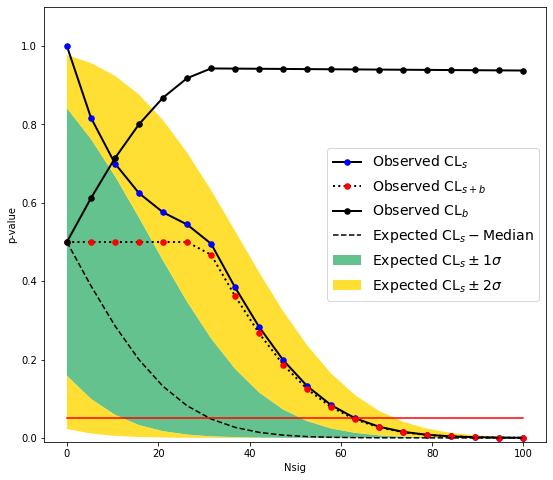

In [8]:
# instantation of the discovery test
ul = UpperLimit(calculator, poi_scan, poi_bkg_only)
ul.upperlimit(alpha=0.05, CLs=False);

f = plt.figure(figsize=(9, 8))
plotlimit(ul, alpha=0.05, CLs=False)
plt.xlabel("Nsig");

#### Upper limit with uncertainty on the background prediction:

Let's assume for now that the estimation of the background yield is 
$$ Nbkg = 340 \pm 25.$$
We add a Gaussian constraint on the likelihood and let *Nbkg* float.

In [9]:
nbkg_constr = zfit.constraint.GaussianConstraint(params=Nbkg, observation=340, uncertainty=25)
nll.add_constraints(nbkg_constr)
Nbkg.floating = True

Get fit best values!


/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
------------------------------------------------------------------
| FCN = 8.014                   |      Ncalls=25 (25 total)      |
| EDM = 4.66e-09 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
--

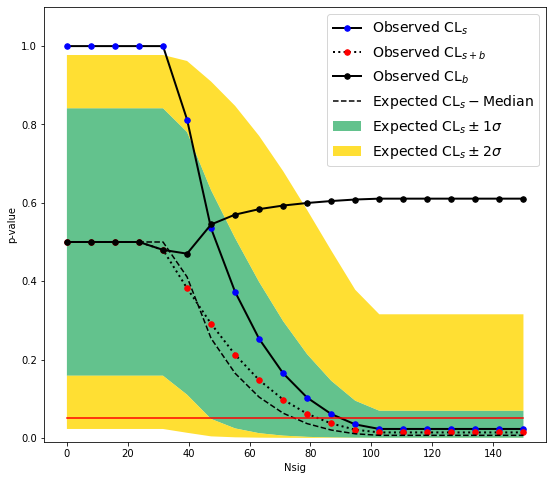

In [10]:
# instantation of the calculator
calculator = AsymptoticCalculator(nll, Minuit(verbosity=0))

# instantation of the discovery test
poi_scan = POIarray(Nsig, np.linspace(0.0, 150, 20))
ul = UpperLimit(calculator, poi_scan, poi_bkg_only)
ul.upperlimit(alpha=0.05, CLs=False);

f = plt.figure(figsize=(9, 8))
plotlimit(ul, alpha=0.05, CLs=False)
plt.xlabel("Nsig");

### Inferences with the `FrequentistCalculator`

In [11]:
nll = UnbinnedNLL(model=model, data=data)
Nbkg.set_value(nbkg)
Nbkg.floating = False

calculator = FrequentistCalculator(nll, minimizer, ntoysalt=1000, ntoysnull=1000)
calculator.bestfit = minimum #optionnal

#### Discovery test:

In [12]:
discovery_test = Discovery(calculator, POI(Nsig, 0))
pnull, significance = discovery_test.result()

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


Generating null hypothesis toys for POI('Nsig', value=0.0).




p_value for the Null hypothesis = 0.061
Significance (in units of sigma) = 1.546433122256748


#### Upper limit:

Generating null hypothesis toys for POI('Nsig', value=5.2631578947368425).



Generating null hypothesis toys for POI('Nsig', value=10.526315789473685).



Generating null hypothesis toys for POI('Nsig', value=15.789473684210527).



Generating null hypothesis toys for POI('Nsig', value=21.05263157894737).



Generating null hypothesis toys for POI('Nsig', value=26.315789473684212).



Generating null hypothesis toys for POI('Nsig', value=31.578947368421055).



Generating null hypothesis toys for POI('Nsig', value=36.8421052631579).



Generating null hypothesis toys for POI('Nsig', value=42.10526315789474).



Generating null hypothesis toys for POI('Nsig', value=47.36842105263158).



Generating null hypothesis toys for POI('Nsig', value=52.631578947368425).



Generating null hypothesis toys for POI('Nsig', value=57.89473684210527).



Generating null hypothesis toys for POI('Nsig', value=63.15789473684211).



Generating null hypothesis toys for POI('Nsig', value=68.42105263157896).



Generating null hypothesis toys for POI('Nsig', value=73.6842105263158).



Generating null hypothesis toys for POI('Nsig', value=78.94736842105263).



Generating null hypothesis toys for POI('Nsig', value=84.21052631578948).



Generating null hypothesis toys for POI('Nsig', value=89.47368421052633).



Generating null hypothesis toys for POI('Nsig', value=94.73684210526316).



Generating null hypothesis toys for POI('Nsig', value=100.0).



Generating alternative hypothesis toys for POI('Nsig', value=0.0).




Observed upper limit: Nsig = 62.535309240679794
Expected upper limit: Nsig = 33.07900562463158
Expected upper limit +1 sigma: Nsig = 51.27319718157931
Expected upper limit -1 sigma: Nsig = 12.992555670108523
Expected upper limit +2 sigma: Nsig = 70.17684661602938
Expected upper limit -2 sigma: Nsig = None


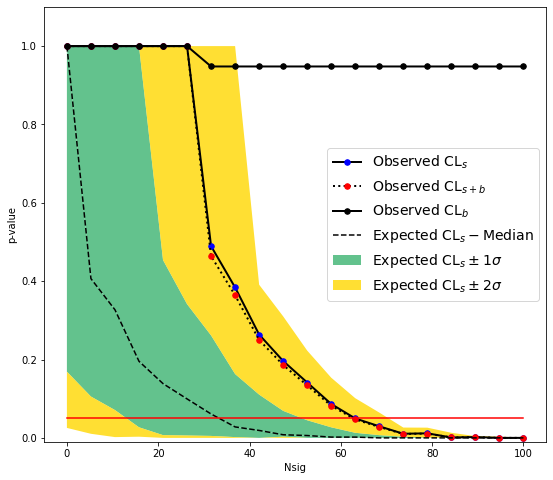

In [13]:
# parameter of interest to scan
poi_scan = POIarray(Nsig, np.linspace(0.0, 100, 20))
# parameter of interest set at the background only hypothesi
poi_bkg_only = POI(Nsig, 0)

# instantation of the discovery test
ul = UpperLimit(calculator, poi_scan, poi_bkg_only)
ul.upperlimit(alpha=0.05, CLs=False);

f = plt.figure(figsize=(9, 8))
plotlimit(ul, alpha=0.05, CLs=False)
plt.xlabel("Nsig");